In [5]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal

In [6]:
# cpu is faster here due to the fact, that the bottle neck is within querying the env, rather that processing of the trajectories
device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# Vanilla PPO
class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma = 0.99, batch_size=64, epsilon=0.2, pi_lr=5e-4, v_lr=5e-4, epoch_n=30):
        super().__init__()
        
        self.pi_model = nn.Sequential(
            nn.Linear(state_dim, 64), 
            nn.ReLU(), 
            nn.Linear(64, 2 * action_dim),
            nn.Tanh())
        self.v_model = nn.Sequential(
            nn.Linear(state_dim, 64), 
            nn.ReLU(), 
            nn.Linear(64, 1))
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)
        self.epoch_n = epoch_n
        

    def get_action(self, state):
        state_tensor = torch.FloatTensor(state).to(device)        
        pi_out = self.pi_model(state_tensor.unsqueeze(0))
        mean = pi_out[:, :self.action_dim]
        log_std = pi_out[:, self.action_dim:]
        dist = Normal(mean, torch.exp(log_std))
        action = dist.sample()
        return action.squeeze(0).cpu().numpy()

    def fit(self, states, actions, rewards, dones):
        states, action, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)
        returns = np.zeros_like(rewards)
        returns[-1] = rewards[-1]
        for t in range(rewards.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t+1]

        states, actions, returns = map(torch.FloatTensor, map(np.array, [states, actions, returns]))
        states = states.to(device)
        actions = actions.to(device)
        returns = returns.to(device)

        pi_out = self.pi_model(states)
        mean = pi_out[:, :self.action_dim]
        log_std = pi_out[:, self.action_dim:]
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i:i + self.batch_size]
                b_states = states[b_idxs]
                b_actions  = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]
    
                b_advantage = b_returns - self.v_model(b_states)

                b_pi_out = self.pi_model(b_states)
                b_mean = b_pi_out[:, :self.action_dim]
                b_log_std = b_pi_out[:, self.action_dim:]
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1 - self.epsilon, 1 + self.epsilon) * b_advantage.detach()
                
                pi_loss = -torch.mean(torch.min(pi_loss_1, pi_loss_2))
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean(b_advantage ** 2)
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

Training <class '__main__.PPO'>


Episode:   0%|          | 0/100 [00:00<?, ?it/s]

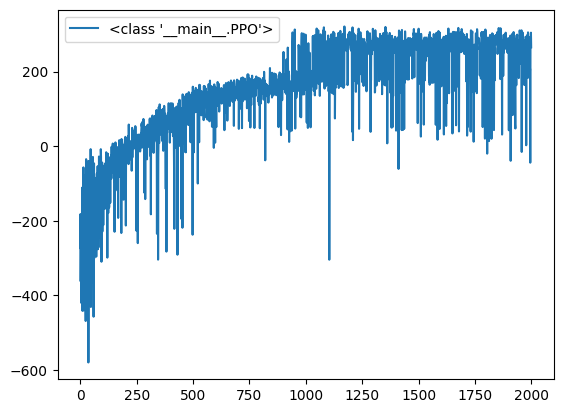

In [8]:
from tqdm.auto import tqdm

agent_histories = []
env = gym.make('LunarLander-v2', continuous=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agents = [
    PPO(state_dim, action_dim).to(device),
]

for agent in agents:
    print(f"Training {type(agent)}")
    episode_n = 100
    trajectory_n = 20
    
    total_rewards = []
    for episode in tqdm(range(episode_n), desc="Episode"):
        states, actions, rewards, dones = [], [], [], []
    
        for _ in range(trajectory_n):
            state = env.reset()
            total_reward = 0
    
            for t in range(1024):
                states.append(state)
                action = agent.get_action(state)
                actions.append(action)
        
                state, reward, done, _ = env.step(action)
                rewards.append(reward)
                dones.append(done)
        
                total_reward += reward
                if done:
                    break
                    
            total_rewards.append(total_reward)
        agent.fit(states, actions, rewards, dones)
    plt.plot(total_rewards, label=str(type(agent)))
    agent_histories.append(total_rewards)
plt.legend()
plt.show()

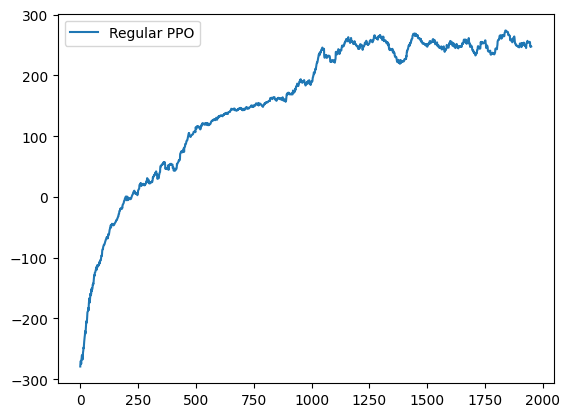

In [11]:
window_size = 50
smoothed_PPO = np.convolve(agent_histories[0], np.ones(window_size)/window_size, mode='valid')
plt.plot(smoothed_PPO, label = "Regular PPO")
plt.legend()
plt.show()